# Imports

In [12]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from mpl_toolkits import mplot3d

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Clean

In [13]:
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [14]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])

# include a variable which tells if a grid is in socat location
# so that we can split a test set during the model training
merged_dataset = xr.merge([merged_dataset, ds['pCO2']['socat_mask']])

In [15]:
df = merged_dataset.to_dataframe().reset_index()

In [16]:
df.dropna(subset=['xlon', 'ylat','pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)

In [17]:
X = np.array(df[['xlon', 'ylat', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl']])

In [18]:
Y = np.array(df[['pCO2']])

In [38]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)

In [39]:
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models

## Neural Network and Regression

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_initializer='normal')])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [29]:
history = model.fit(X_train, Y_train, epochs=5, batch_size = 320)

Epoch 1/5
12967852/12967852 [==============================] - 50s 4us/step - loss: 1702.2473 - mean_squared_error: 1702.2473
Epoch 2/5
12967852/12967852 [==============================] - 50s 4us/step - loss: 456.4108 - mean_squared_error: 456.4108
Epoch 3/5
12967852/12967852 [==============================] - 49s 4us/step - loss: 416.3223 - mean_squared_error: 416.3223
Epoch 4/5
12967852/12967852 [==============================] - 50s 4us/step - loss: 395.4613 - mean_squared_error: 395.4613
Epoch 5/5
12967852/12967852 [==============================] - 50s 4us/step - loss: 383.6237 - mean_squared_error: 383.6237


In [49]:
np.sqrt(383)

19.570385790780925

In [30]:
a = model.evaluate(X_test, Y_test)

4322618/4322618 [==============================] - 54s 13us/step


In [31]:
tss = np.sum(np.square(Y_train - np.mean(Y_train)))

In [32]:
tss_test = np.sum(np.square(Y_test - np.mean(Y_test)))

In [33]:
reg = LinearRegression().fit(X_train, Y_train)

In [34]:
print('Neural Network Train R squared:', 1 - (history.history['loss'][-1]*X_train.shape[0]/tss))

Neural Network Train R squared: 0.8068162438053249


In [35]:
print('Neural Network  Test R squared:', 1 - (a[0]*X_test.shape[0]/tss_test))

Neural Network  Test R squared: 0.8098447300883592


In [36]:
print('Regression Train R squared:', reg.score(X_train, Y_train))

Regression Train R squared: 0.41055895381641816


In [37]:
print('Regression Test R squared:', reg.score(X_test, Y_test))

Regression Test R squared: 0.41102077257162795


## K-Means

In [40]:
clustering = MiniBatchKMeans(n_clusters=3)

In [41]:
labels = clustering.fit_predict(X_train)

In [42]:
a = 0
b = 10000

Text(0.5,0,'pco2')

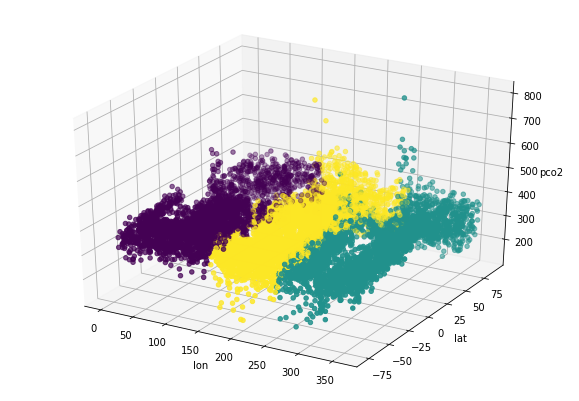

In [54]:
plt.figure('Iris dataset', figsize=(10,7))
ax = plt.axes(projection = '3d')
ax.scatter(X_train[a:b][:,0],X_train[a:b][:,1],Y_train[a:b],c=labels[a:b])
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_zlabel('pco2')

In [15]:
feat = ['xlon', 'ylat', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl']